In [ ]:
#IMPORT ALL THE REQUIRED LIBERARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# Optional: for warnings suppression
import warnings
warnings.filterwarnings('ignore')

# Set visualizations inline
%matplotlib inline

In [ ]:
# Load the dataset (....)
CAREGIVERS = pd.read_csv('CAREGIVERS.csv.gz')

# Preview the dataset
CAREGIVERS.head(10)

,ROW_ID,CGID,LABEL,DESCRIPTION
0,2228,16174,RO,Read Only
1,2229,16175,RO,Read Only
2,2230,16176,Res,Resident/Fellow/PA/NP
3,2231,16177,RO,Read Only
4,2232,16178,RT,Respiratory
5,2233,16179,Res,Resident/Fellow/PA/NP
6,2234,16180,Rehab,Rehabilitation
7,2235,16181,MD,NaN
8,2236,16182,CM,Case Manager
9,2237,16183,Rehab,Rehabilitation


In [ ]:
CAREGIVERS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7567 entries, 0 to 7566
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       7567 non-null   int64 
 1   CGID         7567 non-null   int64 
 2   LABEL        7518 non-null   object
 3   DESCRIPTION  5155 non-null   object
dtypes: int64(2), object(2)
memory usage: 236.6+ KB


In [ ]:
# Checking missing values in each column
missing_values_CAREGIVERS = CAREGIVERS.isnull().sum()
missing_values_CAREGIVERS[missing_values_CAREGIVERS > 0]

LABEL            49
DESCRIPTION    2412
dtype: int64

In [ ]:


# LABEL: fill with 'UNKNOWN'
CAREGIVERS['LABEL'].fillna('UNKNOWN', inplace=True)

# DIAGNOSIS: fill with 'NOT RECORDED'
CAREGIVERS['DESCRIPTION'].fillna('UNKNOWN', inplace=True)

In [ ]:
# Check duplicates
duplicates_CAREGIVERS = CAREGIVERS.duplicated().sum()
print(f'Total duplicate rows: {duplicates_CAREGIVERS}')

# Drop duplicates if necessary
CAREGIVERS.drop_duplicates(inplace=True)

Total duplicate rows: 0


In [ ]:
import pandas as pd

CAREGIVERS_cleaned = pd.read_csv('CAREGIVERS.csv.gz')

In [ ]:
# Verify first
print(CAREGIVERS_cleaned.head())

# Then clearly save it
CAREGIVERS_cleaned.to_csv('CAREGIVERS_cleaned.csv', index=False)

   ROW_ID   CGID LABEL            DESCRIPTION
0    2228  16174    RO              Read Only
1    2229  16175    RO              Read Only
2    2230  16176   Res  Resident/Fellow/PA/NP
3    2231  16177    RO              Read Only
4    2232  16178    RT            Respiratory


In [ ]:
!pip install sdv

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import sdv
print(sdv.__version__)


1.23.0


In [ ]:
# Imports

from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata


In [ ]:
CAREGIVERS_cleaned = pd.read_csv('CAREGIVERS_cleaned.csv')
CAREGIVERS_cleaned.head()


,ROW_ID,CGID,LABEL,DESCRIPTION
0,2228,16174,RO,Read Only
1,2229,16175,RO,Read Only
2,2230,16176,Res,Resident/Fellow/PA/NP
3,2231,16177,RO,Read Only
4,2232,16178,RT,Respiratory


In [ ]:
# Imports
import pandas as pd
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import os

#  Fix multiprocessing on Windows
os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["JOBLIB_START_METHOD"] = "spawn"

#  Load the dataset
CAREGIVERS = pd.read_csv("CAREGIVERS.csv.gz")

#  just save the raw dataset as 'cleaned' for pipeline compatibility
CAREGIVERS.to_csv("CAREGIVERS_cleaned.csv", index=False)

#  Reload for synthesis
CAREGIVERS_cleaned = pd.read_csv("CAREGIVERS_cleaned.csv")

#  Generate metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(CAREGIVERS_cleaned)

#  Initialize synthesizer
synthesizer = CTGANSynthesizer(
    metadata=metadata,
    epochs=30
)

#  Fit the synthesizer
synthesizer.fit(CAREGIVERS_cleaned)

#  Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=1000)

#  Save synthetic data
synthetic_data.to_csv("synthetic_CAREGIVERS.csv", index=False)

#  Preview
print(" Synthetic data generated successfully:")
synthetic_data.head()


 Synthetic data generated successfully:


,ROW_ID,CGID,LABEL,DESCRIPTION
0,16207964,14922,StPh,RN
1,12940916,18750,RO,NaN
2,545602,16628,NuStud,Read Only
3,7179090,14001,CM,Pharmacist
4,7836865,17172,Par,Attending


In [ ]:
#  Fit the model (MUST come before sample)
synthesizer.fit(CAREGIVERS_cleaned)



In [ ]:
# Now try sampling again
synthetic_data = synthesizer.sample(num_rows=1000)
synthetic_data.to_csv("synthetic_CAREGIVERS.csv", index=False)
synthetic_data.head()

,ROW_ID,CGID,LABEL,DESCRIPTION
0,16207964,15445,MD,RN
1,12940916,19822,NuStud,NaN
2,545602,16723,RO,Read Only
3,7179090,14297,CM,NaN
4,7836865,14089,MD,Attending


In [ ]:
print("Synthesizer fitted:", synthesizer._fitted)

Synthesizer fitted: True


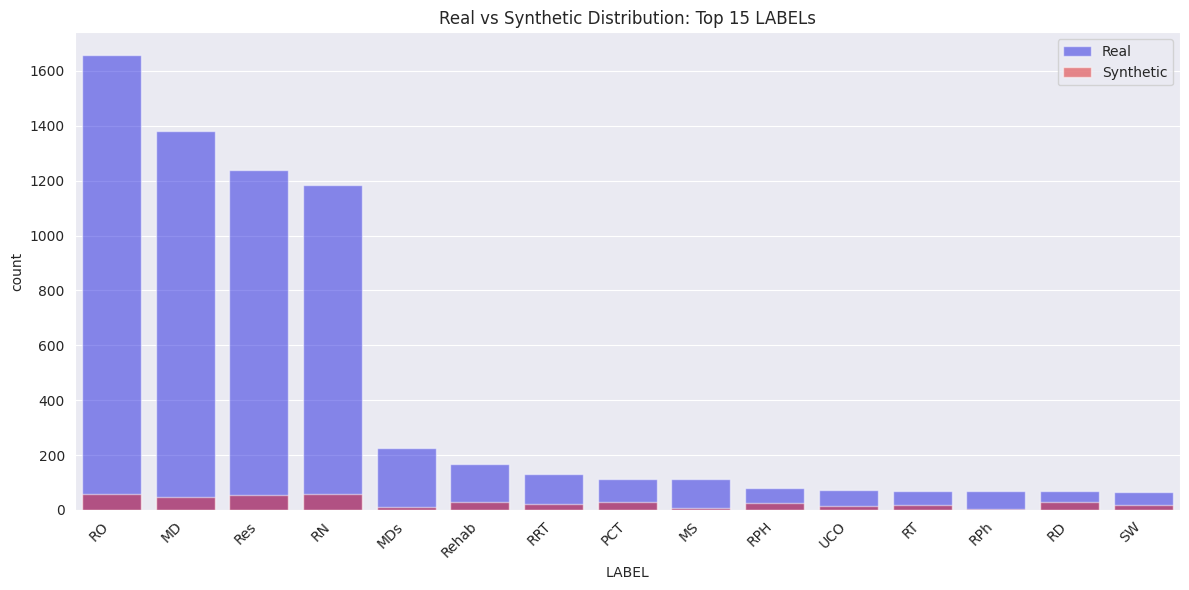

In [ ]:
# Compute top N labels by frequency
top_labels = CAREGIVERS_cleaned['LABEL'].value_counts().nlargest(15).index

# Filter both datasets to include only top labels
real_top = CAREGIVERS_cleaned[CAREGIVERS_cleaned['LABEL'].isin(top_labels)]
synthetic_top = synthetic_data[synthetic_data['LABEL'].isin(top_labels)]

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(x='LABEL', data=real_top, color='blue', label='Real', alpha=0.5, order=top_labels)
sns.countplot(x='LABEL', data=synthetic_top, color='red', label='Synthetic', alpha=0.5, order=top_labels)
plt.legend()
plt.title("Real vs Synthetic Distribution: Top 15 LABELs")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [ ]:
#  Load synthetic dataset if not already in memory
synthetic = pd.read_csv("synthetic_CAREGIVERS.csv")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Example: Predict HOSPITAL_EXPIRE_FLAG using synthetic vs real
features = ['LABEL', 'DESCRIPTION']
target = 'LABEL'

# Preprocessing (convert categories to codes)
for col in features:
    CAREGIVERS_cleaned[col] = CAREGIVERS_cleaned[col].astype('category').cat.codes
    synthetic[col] = synthetic[col].astype('category').cat.codes


# Real data model
X_real = CAREGIVERS_cleaned[features]
y_real = CAREGIVERS_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3)

model_real = RandomForestClassifier()
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# Synthetic data model
X_syn = synthetic[features]
y_syn = synthetic[target]
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_syn, y_syn, test_size=0.3)

model_syn = RandomForestClassifier()
model_syn.fit(Xs_train, ys_train)
syn_acc = accuracy_score(ys_test, model_syn.predict(Xs_test))

print(f" Model accuracy on real data: {real_acc:.2f}")
print(f" Model accuracy on synthetic data: {syn_acc:.2f}")

 Model accuracy on real data: 0.96
 Model accuracy on synthetic data: 0.57


In [ ]:
#  Import TVAESynthesizer
from sdv.single_table import TVAESynthesizer

#  Initialize VAE synthesizer
vae_synthesizer = TVAESynthesizer(
    metadata=metadata,
    epochs=30  # Same as CTGAN for fair comparison
)

#  Fit the VAE synthesizer
vae_synthesizer.fit(CAREGIVERS_cleaned)

#  Sample synthetic data using VAE
synthetic_data_vae = vae_synthesizer.sample(num_rows=1000)

#  Save VAE synthetic data
synthetic_data_vae.to_csv('synthetic_CAREGIVERS_vae.csv', index=False)

#  Preview VAE synthetic data
synthetic_data_vae.head()


,ROW_ID,CGID,LABEL,DESCRIPTION
0,16207964,21003,71,-1
1,12940916,14547,71,12
2,545602,14266,146,8
3,7179090,14832,172,12
4,7836865,20808,71,-1


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load your synthetic data generated from VAE
synthetic_vae = pd.read_csv('synthetic_CAREGIVERS_vae.csv')

# Preprocessing: convert categorical columns to numeric codes (if not already)
features = ['LABEL','DESCRIPTION']
target = 'LABEL'

# Make sure all datasets are prepared
for col in features:
    CAREGIVERS_cleaned[col] = CAREGIVERS_cleaned[col].astype('category').cat.codes
    synthetic_vae[col] = synthetic_vae[col].astype('category').cat.codes

# Real data model (already trained if you want, but re-training to be safe)
X_real = CAREGIVERS_cleaned[features]
y_real = CAREGIVERS_cleaned[target]
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_real, y_real, test_size=0.3, random_state=42)

model_real = RandomForestClassifier(random_state=42)
model_real.fit(Xr_train, yr_train)
real_acc = accuracy_score(yr_test, model_real.predict(Xr_test))

# VAE Synthetic data model
X_vae = synthetic_vae[features]
y_vae = synthetic_vae[target]
Xv_train, Xv_test, yv_train, yv_test = train_test_split(X_vae, y_vae, test_size=0.3, random_state=42)

model_vae = RandomForestClassifier(random_state=42)
model_vae.fit(Xv_train, yv_train)
vae_acc = accuracy_score(yv_test, model_vae.predict(Xv_test))

# Show results
print(f" Model accuracy on real data:       {real_acc:.2f}")
print(f" Model accuracy on VAE synthetic data: {vae_acc:.2f}")


 Model accuracy on real data:       0.97
 Model accuracy on VAE synthetic data: 1.00


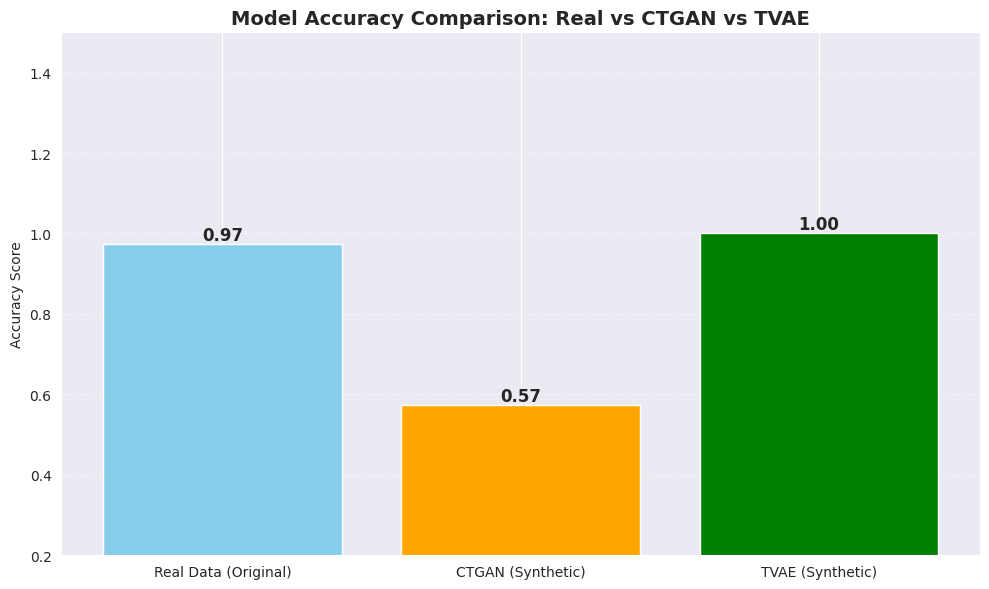

In [ ]:
import matplotlib.pyplot as plt

#  accuracy values
# These are from your previous results:
real_acc = real_acc          # Accuracy on real data using real training
vae_acc = vae_acc           # Accuracy on synthetic VAE data
gan_acc = syn_acc           # Accuracy on synthetic GAN (CTGAN) data

# Prepare bar chart data
labels = ['Real Data (Original)', 'CTGAN (Synthetic)', 'TVAE (Synthetic)']
accuracy_scores = [real_acc, gan_acc, vae_acc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracy_scores, color=['skyblue', 'orange', 'green'])

#  chart elements
plt.title('Model Accuracy Comparison: Real vs CTGAN vs TVAE', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy Score')
plt.ylim(0.2, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate bars
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
